In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In this scipt the data is NOT smoothened 

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
dset = open_s3fs('PC-data')
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# rewriting the name of the variables 
uvar = dset.vozocrtx.isel(y=slice(800,1800), x=slice(200,1400))
vvar = dset.vomecrty.isel(y=slice(800,1800), x=slice(200,1400))
uv = dset.vel.isel(y=slice(800,1800), x=slice(200,1400))

In [5]:
# Getting the bottom velocity 
d = dset.mbathy.isel(y=slice(800,1800), x=slice(200,1400)).values-1 
d[d==-1] = 0

d = xr.DataArray(d, dims=['y','x'])

uvar_b = uvar.isel(depth=d)
vvar_b = vvar.isel(depth=d)
uv_b = uv.isel(depth=d)

In [6]:
# List of x,y elements
dx = 20
dy = 20

jmax, imax = uv_b.shape
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

In [7]:
# Making the covmatrix and finding the eigenvalues and eigenvectors
# ----------------------------------------------------------------------
PC11 = []
PC12 = []
PC21 = []
PC22 = []
y = []
x = []
indx = 0

In [8]:
# to get the loop to run faster
uvy = np.array(uv_b.y.values)
uvx = np.array(uv_b.x.values)


uvarb = np.array(uvar_b.values)
vvarb = np.array(vvar_b.values)
uvb = np.array(uv_b.values)

for i in i_list:
    for j in j_list:
        covm = np.array([[uvarb[j,i],uvb[j,i]],
        [uvb[j,i],vvarb[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            values, vectors = np.linalg.eig(covm)
            #eig_pairs = [(np.abs(values[i]), vectors[:,i]) for i in range(len(values))]
            #print('Eigenvalues in descending order:')
            #for i in eig_pairs:
            #     = i[0]
            
            PC11.append(vectors[0,0]*np.sqrt(values[0]))
            PC12.append(vectors[1,0]*np.sqrt(values[0]))
            PC21.append(vectors[0,1]*np.sqrt(values[1]))
            PC22.append(vectors[1,1]*np.sqrt(values[1]))
            y.append(uvy[j])
            x.append(uvx[i])
            indx += 1
# converting to np.arrays
PC11 = np.array(PC11,dtype=float)
PC12 = np.array(PC12,dtype=float)
PC21 = np.array(PC21,dtype=float)
PC22 = np.array(PC22,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)


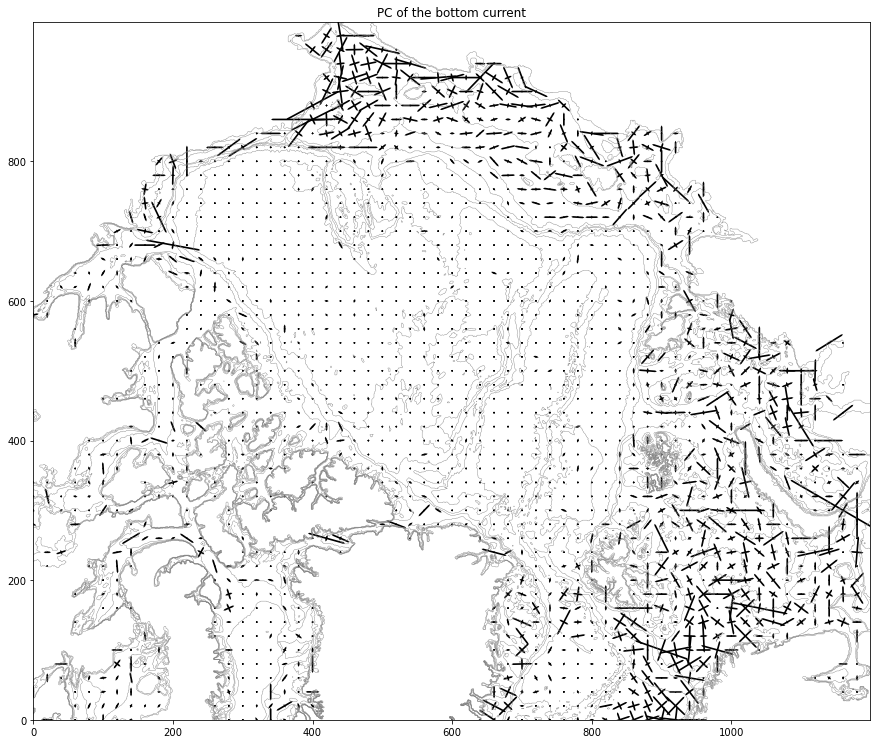

In [9]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the bottom current')
ax.contour(dset.mbathy[800:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11[::1], PC12[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::1], y[::1], -PC11[::1], -PC12[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], PC21[::1], PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], -PC21[::1], -PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.set_aspect('equal')

plt.show()

Fig. XX shows the bottom current 65.65 to 59,25 degree North, and -89,19 to 114.87 degree East. The largest variance of the currents can be found on the shallower areas, as exemple on the shelf or in the Barents sea. The Bering strait, which has an average depth of 50m (https://www.britannica.com/place/Bering-Strait), shows a larger variance than the Fram stait, which is significantly deeper. 

The variance is weakest at the deeper parts of the arctic ocean. It is also here we can find the clearest signal of topogtaphic steering. Along the shelf the PC are almost purly in one direction, indicating strong topographic steering.  